## Linear.py

In [1]:
import torch.nn as nn
import torch.nn.functional as F
import math

class Linear(nn.Module):

    def __init__(self, num_classes=2):

        super(Linear, self).__init__()

        self.number_class   = num_classes

        _size_image     = 100* 100
        _num1           = 50
        _num2           = 60
        
        self.fc1        = nn.Linear(_size_image, _num1, bias=True)
        self.fc2        = nn.Linear(_num1, _num2, bias=True)
        self.fc3        = nn.Linear(_num2, num_classes, bias=True)

        self.fc_layer1  = nn.Sequential(self.fc1, nn.LeakyReLU(True))
        self.fc_layer2  = nn.Sequential(self.fc2, nn.LeakyReLU(True))
        self.fc_layer3  = nn.Sequential(self.fc3, nn.Sigmoid())
        
        self.classifier = nn.Sequential(self.fc_layer1, self.fc_layer2, self.fc_layer3)
        
        self._initialize_weight()        
        
    def _initialize_weight(self):

        for name, m in self._modules.items():
            if isinstance(m, nn.Linear):
                n = m.in_features
                m.weight.data.uniform_(- 1.0 / math.sqrt(n), 1.0 / math.sqrt(n))

                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):

        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x


## load data

In [2]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import argparse
import sys
import os
import numpy as np
import time
import datetime 
import csv
import configparser
import argparse
import platform
import torchvision.transforms as transforms
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
from random import shuffle

# -----------------------------------------------------------------------------
# load dataset
# -----------------------------------------------------------------------------


transform = transforms.Compose([#transforms.Resize((256,256)),  
                                transforms.Grayscale(),		# the code transforms.Graysclae() is for changing the size [3,100,100] to [1, 100, 100] (notice : [channel, height, width] )
                                transforms.ToTensor(),])


#train_data_path = 'relative path of training data set'
train_data_path = './horse-or-human/horse-or-human/train'
trainset = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
# if shuffle=True, the data reshuffled at every epoch 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=3, shuffle=True, num_workers=1)  


validation_data_path = './horse-or-human/horse-or-human/validation'
valset = torchvision.datasets.ImageFolder(root=validation_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
valloader = torch.utils.data.DataLoader(valset, batch_size=3, shuffle=True, num_workers=1)


## train dataset + get loss and accuracy

In [8]:
num_classes = 2

# -----------------------------------------------------------------------------
# load neural network model
# -----------------------------------------------------------------------------

model = Linear(num_classes=num_classes)

# -----------------------------------------------------------------------------
# Set the flag for using cuda
# -----------------------------------------------------------------------------

bCuda = 1

if bCuda:
 
    model.cuda()

# -----------------------------------------------------------------------------
# optimization algorithm
# -----------------------------------------------------------------------------

optimizer   = optim.SGD(model.parameters(), lr=0.015, weight_decay=0.09)
# reduce lr
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, min_lr=0.001, verbose=1, factor = 0.25)
objective   = nn.CrossEntropyLoss()

# -----------------------------------------------------------------------------
# function for training the model
# -----------------------------------------------------------------------------

def train():

    # print('train the model at given epoch')
    accuracy_train = []
    loss_train = []
    correct = 0
    correct_batch = 0

    model.train()
    for idx_batch, (data, target) in enumerate(trainloader):

        if bCuda:
        
            data, target    = data.cuda(), target.cuda()

        data, target    = Variable(data), Variable(target)

        optimizer.zero_grad()

        output  = model(data)
        loss    = objective(output, target)

        loss.backward()
        optimizer.step()

        loss_train_batch    = loss.item() / len(data)
        loss_train.append(loss_train_batch)
        pred        = output.data.max(1)[1]
        correct     += pred.eq(target.data.view_as(pred)).cpu().sum()
        correct_batch = pred.eq(target.data.view_as(pred)).cpu().sum()
        accuracy_train_batch = float(correct_batch) / len(data)
        accuracy_train.append(accuracy_train_batch)
        
    loss_train_mean     = np.mean(loss_train)
    loss_train_std      = np.std(loss_train)
    accuracy_train_mean   = float(correct) / len(trainloader.dataset)  # mean accuracy
    accuracy_train_std  = np.std(accuracy_train)

    return {'loss_train_mean': loss_train_mean, 'loss_train_std': loss_train_std, 'accuracy_train_mean' : accuracy_train_mean, 'accuracy_train_std' : accuracy_train_std}

# -----------------------------------------------------------------------------
# function for testing the model
# -----------------------------------------------------------------------------

def test():

    # print('test the model at given epoch')

    accuracy_test   = []
    loss_test       = 0
    correct         = 0

    model.eval()

    for idx_batch, (data, target) in enumerate(valloader):

        if bCuda:
        
            data, target    = data.cuda(), target.cuda()

        data, target    = Variable(data), Variable(target)

        output  = model(data)
        loss    = objective(output, target)

        loss_test   += loss.item()
        pred        = output.data.max(1)[1]
        correct     += pred.eq(target.data.view_as(pred)).cpu().sum()

    loss_test       = loss_test / len(valloader.dataset)
    accuracy_test   = float(correct) / len(valloader.dataset)

    return {'loss_test': loss_test, 'accuracy_test': accuracy_test}

# -----------------------------------------------------------------------------
# iteration for the epoch
# -----------------------------------------------------------------------------

loss_train_mean, loss_train_std, loss_test, accuracy_test, accuracy_train_mean, accuracy_train_std = [], [], [], [], [], []
loss_temp = 0;

for e in range(3000):
    
    result_train    = train()
    result_test     = test()
    scheduler.step(result_test['loss_test'], e)

    
    loss_train_mean.append(result_train['loss_train_mean'])
    loss_train_std.append(result_train['loss_train_std'])
    loss_test.append(result_test['loss_test'])
    accuracy_test.append(result_test['accuracy_test'])
    accuracy_train_mean.append(result_train['accuracy_train_mean'])
    accuracy_train_std.append(result_train['accuracy_train_std'])
    
    print(f"[epoch {e}] loss: (training) {loss_train_mean[-1]} , (testing) {loss_test[-1]} , accuracy: (training) {result_train['accuracy_train_mean']} ,    (testing) {accuracy_test[-1]}")
    
    if(abs(loss_temp - loss_train_mean[-1]) < 10e-7):
        break;
    loss_temp = loss_train_mean[-1]


[epoch 0] loss: (training) 0.2265858790964844 , (testing) 0.2152228282066062 , accuracy: (training) 0.5647517039922103 ,    (testing) 0.53515625
[epoch 1] loss: (training) 0.2144880304067777 , (testing) 0.19034805509727448 , accuracy: (training) 0.6407010710808179 ,    (testing) 0.796875
[epoch 2] loss: (training) 0.20403098428678004 , (testing) 0.17022359685506672 , accuracy: (training) 0.7010710808179162 ,    (testing) 0.8828125
[epoch 3] loss: (training) 0.197899952255718 , (testing) 0.19670539547223598 , accuracy: (training) 0.7293086660175268 ,    (testing) 0.6171875
[epoch 4] loss: (training) 0.19567342497864548 , (testing) 0.16360900993458927 , accuracy: (training) 0.7351509250243428 ,    (testing) 0.875
[epoch 5] loss: (training) 0.19531761762931352 , (testing) 0.16495803254656494 , accuracy: (training) 0.7166504381694255 ,    (testing) 0.875
Epoch     6: reducing learning rate of group 0 to 3.7500e-03.
[epoch 6] loss: (training) 0.19260927855215454 , (testing) 0.16916748462244

[epoch 56] loss: (training) 0.17443505621744199 , (testing) 0.1530163042480126 , accuracy: (training) 0.8364167478091529 ,    (testing) 0.8828125
[epoch 57] loss: (training) 0.17511707686242606 , (testing) 0.1625884686363861 , accuracy: (training) 0.8422590068159689 ,    (testing) 0.83984375
[epoch 58] loss: (training) 0.17374874994636624 , (testing) 0.16011709242593497 , accuracy: (training) 0.8451801363193768 ,    (testing) 0.84765625
[epoch 59] loss: (training) 0.1737885064471683 , (testing) 0.1529998554615304 , accuracy: (training) 0.8403115871470301 ,    (testing) 0.8828125
[epoch 60] loss: (training) 0.1743511651996505 , (testing) 0.15531535376794636 , accuracy: (training) 0.8422590068159689 ,    (testing) 0.87890625
[epoch 61] loss: (training) 0.17336300528084223 , (testing) 0.1576859598280862 , accuracy: (training) 0.8471275559883155 ,    (testing) 0.86328125
[epoch 62] loss: (training) 0.17427689123779275 , (testing) 0.15683057566639036 , accuracy: (training) 0.850048685491723

[epoch 112] loss: (training) 0.17226698221340123 , (testing) 0.15388035506475717 , accuracy: (training) 0.8519961051606622 ,    (testing) 0.88671875
[epoch 113] loss: (training) 0.17213709952184827 , (testing) 0.15431015274953097 , accuracy: (training) 0.8500486854917235 ,    (testing) 0.8828125
[epoch 114] loss: (training) 0.1727146325294432 , (testing) 0.15564979263581336 , accuracy: (training) 0.8422590068159689 ,    (testing) 0.87890625
[epoch 115] loss: (training) 0.17139065729054118 , (testing) 0.15406115201767534 , accuracy: (training) 0.8558909444985394 ,    (testing) 0.8828125
[epoch 116] loss: (training) 0.17231394004427888 , (testing) 0.15353275637608021 , accuracy: (training) 0.8490749756572541 ,    (testing) 0.890625
[epoch 117] loss: (training) 0.17219790969807855 , (testing) 0.15356844838242978 , accuracy: (training) 0.8490749756572541 ,    (testing) 0.8828125
[epoch 118] loss: (training) 0.17290903052968581 , (testing) 0.15256795065943152 , accuracy: (training) 0.854917

[epoch 168] loss: (training) 0.17146900472881957 , (testing) 0.15231535269413143 , accuracy: (training) 0.8529698149951315 ,    (testing) 0.8828125
[epoch 169] loss: (training) 0.1721641063632261 , (testing) 0.15998215519357473 , accuracy: (training) 0.8529698149951315 ,    (testing) 0.8515625
[epoch 170] loss: (training) 0.1715002841921659 , (testing) 0.1549704025965184 , accuracy: (training) 0.857838364167478 ,    (testing) 0.88671875
[epoch 171] loss: (training) 0.17272246460293658 , (testing) 0.16493385413195938 , accuracy: (training) 0.8490749756572541 ,    (testing) 0.8125
[epoch 172] loss: (training) 0.17191900786435987 , (testing) 0.1604878818616271 , accuracy: (training) 0.8481012658227848 ,    (testing) 0.83984375
[epoch 173] loss: (training) 0.17189175794145456 , (testing) 0.15674213669262826 , accuracy: (training) 0.8490749756572541 ,    (testing) 0.87890625
[epoch 174] loss: (training) 0.17211296598348255 , (testing) 0.15795820928178728 , accuracy: (training) 0.85978578383

[epoch 224] loss: (training) 0.17204913169695868 , (testing) 0.15264968492556363 , accuracy: (training) 0.8471275559883155 ,    (testing) 0.8828125
[epoch 225] loss: (training) 0.17176356717611077 , (testing) 0.16008359740953892 , accuracy: (training) 0.8549172346640701 ,    (testing) 0.84375
[epoch 226] loss: (training) 0.17178154999591172 , (testing) 0.1548355856211856 , accuracy: (training) 0.8549172346640701 ,    (testing) 0.88671875
[epoch 227] loss: (training) 0.17180768628509677 , (testing) 0.16005066805519164 , accuracy: (training) 0.8588120740019474 ,    (testing) 0.84375
[epoch 228] loss: (training) 0.17164648879605432 , (testing) 0.15836035006213933 , accuracy: (training) 0.8510223953261928 ,    (testing) 0.8515625
[epoch 229] loss: (training) 0.1717199506229052 , (testing) 0.15491911384742707 , accuracy: (training) 0.8617332035053554 ,    (testing) 0.88671875
[epoch 230] loss: (training) 0.171571446258658 , (testing) 0.16880216065328568 , accuracy: (training) 0.858812074001

[epoch 280] loss: (training) 0.17132938273099005 , (testing) 0.15287859470117837 , accuracy: (training) 0.8500486854917235 ,    (testing) 0.87890625
[epoch 281] loss: (training) 0.1713490904941503 , (testing) 0.16331226215697825 , accuracy: (training) 0.8510223953261928 ,    (testing) 0.8359375
[epoch 282] loss: (training) 0.17282948720443583 , (testing) 0.16379641834646463 , accuracy: (training) 0.8539435248296008 ,    (testing) 0.828125
[epoch 283] loss: (training) 0.17167044189859063 , (testing) 0.15742157003842294 , accuracy: (training) 0.8529698149951315 ,    (testing) 0.85546875
[epoch 284] loss: (training) 0.17149412701498315 , (testing) 0.15407861419953406 , accuracy: (training) 0.8490749756572541 ,    (testing) 0.88671875
[epoch 285] loss: (training) 0.17214041175022068 , (testing) 0.15400183550082147 , accuracy: (training) 0.8529698149951315 ,    (testing) 0.88671875
[epoch 286] loss: (training) 0.17143825261307874 , (testing) 0.15573176427278668 , accuracy: (training) 0.8519

[epoch 336] loss: (training) 0.17171068844341097 , (testing) 0.15428138803690672 , accuracy: (training) 0.8568646543330087 ,    (testing) 0.87890625
[epoch 337] loss: (training) 0.17124897128639 , (testing) 0.15517828450538218 , accuracy: (training) 0.8500486854917235 ,    (testing) 0.88671875
[epoch 338] loss: (training) 0.17227370091383612 , (testing) 0.15902909054420888 , accuracy: (training) 0.8510223953261928 ,    (testing) 0.8515625
[epoch 339] loss: (training) 0.17110066033313295 , (testing) 0.16268668067641556 , accuracy: (training) 0.8588120740019474 ,    (testing) 0.8359375
[epoch 340] loss: (training) 0.1716605890017325 , (testing) 0.16505415353458375 , accuracy: (training) 0.8568646543330087 ,    (testing) 0.83203125
[epoch 341] loss: (training) 0.17186570005351995 , (testing) 0.16049899836070836 , accuracy: (training) 0.8481012658227848 ,    (testing) 0.8515625
[epoch 342] loss: (training) 0.17220816178386714 , (testing) 0.16425395803526044 , accuracy: (training) 0.8529698

[epoch 392] loss: (training) 0.17141217057049216 , (testing) 0.1565337055362761 , accuracy: (training) 0.8588120740019474 ,    (testing) 0.87890625
[epoch 393] loss: (training) 0.17168334526153764 , (testing) 0.15356159151997417 , accuracy: (training) 0.8539435248296008 ,    (testing) 0.8828125
[epoch 394] loss: (training) 0.17156116428365978 , (testing) 0.16373885481152683 , accuracy: (training) 0.8519961051606622 ,    (testing) 0.8203125
[epoch 395] loss: (training) 0.17179171128453735 , (testing) 0.1535652499878779 , accuracy: (training) 0.8481012658227848 ,    (testing) 0.8828125
[epoch 396] loss: (training) 0.17144506156039077 , (testing) 0.15371706301812083 , accuracy: (training) 0.8529698149951315 ,    (testing) 0.88671875
[epoch 397] loss: (training) 0.17098511811943165 , (testing) 0.15732974919956177 , accuracy: (training) 0.8539435248296008 ,    (testing) 0.85546875
[epoch 398] loss: (training) 0.17158511156475115 , (testing) 0.1522207586094737 , accuracy: (training) 0.850048

[epoch 448] loss: (training) 0.17245968808469783 , (testing) 0.17287953605409712 , accuracy: (training) 0.8558909444985394 ,    (testing) 0.77734375
[epoch 449] loss: (training) 0.17100653767701604 , (testing) 0.15307782706804574 , accuracy: (training) 0.8588120740019474 ,    (testing) 0.89453125
[epoch 450] loss: (training) 0.17256134985950644 , (testing) 0.15195961575955153 , accuracy: (training) 0.857838364167478 ,    (testing) 0.89453125
[epoch 451] loss: (training) 0.17077963999802911 , (testing) 0.162660451955162 , accuracy: (training) 0.8568646543330087 ,    (testing) 0.83203125
[epoch 452] loss: (training) 0.17130249417210458 , (testing) 0.15436118026264012 , accuracy: (training) 0.8588120740019474 ,    (testing) 0.88671875
[epoch 453] loss: (training) 0.1717572974220309 , (testing) 0.1562226943206042 , accuracy: (training) 0.8588120740019474 ,    (testing) 0.87890625
[epoch 454] loss: (training) 0.17193389147433177 , (testing) 0.15226101130247116 , accuracy: (training) 0.85199

[epoch 504] loss: (training) 0.1712622036913046 , (testing) 0.15346044884063303 , accuracy: (training) 0.8558909444985394 ,    (testing) 0.8828125
[epoch 505] loss: (training) 0.17225338522963898 , (testing) 0.15590520680416375 , accuracy: (training) 0.8549172346640701 ,    (testing) 0.88671875
[epoch 506] loss: (training) 0.17249689826812412 , (testing) 0.1543101683491841 , accuracy: (training) 0.8490749756572541 ,    (testing) 0.8828125
[epoch 507] loss: (training) 0.17165088995320918 , (testing) 0.15576649853028357 , accuracy: (training) 0.857838364167478 ,    (testing) 0.87890625
[epoch 508] loss: (training) 0.1713220456540874 , (testing) 0.1569313786458224 , accuracy: (training) 0.8568646543330087 ,    (testing) 0.86328125
[epoch 509] loss: (training) 0.17117654382313655 , (testing) 0.15227725461591035 , accuracy: (training) 0.8597857838364168 ,    (testing) 0.890625
[epoch 510] loss: (training) 0.1710901547972732 , (testing) 0.15743936237413436 , accuracy: (training) 0.8539435248

[epoch 560] loss: (training) 0.17212655940486807 , (testing) 0.15706487535499036 , accuracy: (training) 0.8529698149951315 ,    (testing) 0.859375
[epoch 561] loss: (training) 0.17169727406765908 , (testing) 0.15546791616361588 , accuracy: (training) 0.8558909444985394 ,    (testing) 0.87890625
[epoch 562] loss: (training) 0.17199634266085018 , (testing) 0.16262454027310014 , accuracy: (training) 0.857838364167478 ,    (testing) 0.8359375
[epoch 563] loss: (training) 0.17135224809220279 , (testing) 0.15442912140861154 , accuracy: (training) 0.8539435248296008 ,    (testing) 0.88671875
[epoch 564] loss: (training) 0.17146681592346283 , (testing) 0.15942198736593127 , accuracy: (training) 0.8568646543330087 ,    (testing) 0.84765625
[epoch 565] loss: (training) 0.17193185382380546 , (testing) 0.15437351341824979 , accuracy: (training) 0.8627069133398247 ,    (testing) 0.88671875
[epoch 566] loss: (training) 0.17157788051924042 , (testing) 0.15250116621609777 , accuracy: (training) 0.8617

[epoch 616] loss: (training) 0.17170473409000245 , (testing) 0.1542435853043571 , accuracy: (training) 0.8510223953261928 ,    (testing) 0.8828125
[epoch 617] loss: (training) 0.17153108881676046 , (testing) 0.15455138799734414 , accuracy: (training) 0.857838364167478 ,    (testing) 0.890625
[epoch 618] loss: (training) 0.171711137389766 , (testing) 0.15919827355537564 , accuracy: (training) 0.8519961051606622 ,    (testing) 0.8515625
[epoch 619] loss: (training) 0.171158429571908 , (testing) 0.16131291294004768 , accuracy: (training) 0.8500486854917235 ,    (testing) 0.83984375
[epoch 620] loss: (training) 0.17144390193435957 , (testing) 0.1668927378486842 , accuracy: (training) 0.8627069133398247 ,    (testing) 0.81640625
[epoch 621] loss: (training) 0.17210228927976537 , (testing) 0.15475294517818838 , accuracy: (training) 0.8471275559883155 ,    (testing) 0.8828125
[epoch 622] loss: (training) 0.17142596722112569 , (testing) 0.15651182527653873 , accuracy: (training) 0.852969814995

[epoch 672] loss: (training) 0.1721634906802627 , (testing) 0.16496239427942783 , accuracy: (training) 0.8510223953261928 ,    (testing) 0.8125
[epoch 673] loss: (training) 0.1714097249554244 , (testing) 0.15452619490679353 , accuracy: (training) 0.8529698149951315 ,    (testing) 0.8828125
[epoch 674] loss: (training) 0.17176939166206195 , (testing) 0.16327121097128838 , accuracy: (training) 0.857838364167478 ,    (testing) 0.8359375
[epoch 675] loss: (training) 0.17139877012566065 , (testing) 0.15708710462786257 , accuracy: (training) 0.8519961051606622 ,    (testing) 0.859375
[epoch 676] loss: (training) 0.1728833139348192 , (testing) 0.1602120134048164 , accuracy: (training) 0.8510223953261928 ,    (testing) 0.8515625
[epoch 677] loss: (training) 0.17103398043166326 , (testing) 0.15408189955633134 , accuracy: (training) 0.8558909444985394 ,    (testing) 0.88671875
[epoch 678] loss: (training) 0.17151467735264578 , (testing) 0.15291549486573786 , accuracy: (training) 0.84810126582278

[epoch 728] loss: (training) 0.17095532280594777 , (testing) 0.1587241068482399 , accuracy: (training) 0.8636806231742941 ,    (testing) 0.8515625
[epoch 729] loss: (training) 0.17112286998532836 , (testing) 0.16913830977864563 , accuracy: (training) 0.8558909444985394 ,    (testing) 0.8125
[epoch 730] loss: (training) 0.17130372927418255 , (testing) 0.15358389087487012 , accuracy: (training) 0.8607594936708861 ,    (testing) 0.8828125
[epoch 731] loss: (training) 0.17101979134034137 , (testing) 0.16199546167626977 , accuracy: (training) 0.8627069133398247 ,    (testing) 0.8359375
[epoch 732] loss: (training) 0.1712392373091973 , (testing) 0.15321105916518718 , accuracy: (training) 0.8568646543330087 ,    (testing) 0.8828125
[epoch 733] loss: (training) 0.17207045150799466 , (testing) 0.15247980365529656 , accuracy: (training) 0.8568646543330087 ,    (testing) 0.890625
[epoch 734] loss: (training) 0.17214500562326787 , (testing) 0.16485936206299812 , accuracy: (training) 0.851022395326

[epoch 784] loss: (training) 0.17123659602407115 , (testing) 0.15592537075281143 , accuracy: (training) 0.8597857838364168 ,    (testing) 0.875
[epoch 785] loss: (training) 0.17186828268976093 , (testing) 0.1581419586436823 , accuracy: (training) 0.8558909444985394 ,    (testing) 0.84765625
[epoch 786] loss: (training) 0.17145318818161856 , (testing) 0.15401585889048874 , accuracy: (training) 0.8539435248296008 ,    (testing) 0.8828125
[epoch 787] loss: (training) 0.1720403185217443 , (testing) 0.15709517628420144 , accuracy: (training) 0.8481012658227848 ,    (testing) 0.859375
[epoch 788] loss: (training) 0.17121165793885065 , (testing) 0.1612175296759233 , accuracy: (training) 0.8510223953261928 ,    (testing) 0.83984375
[epoch 789] loss: (training) 0.17121076887967634 , (testing) 0.1528018865501508 , accuracy: (training) 0.8529698149951315 ,    (testing) 0.89453125


## plot accuracy and loss

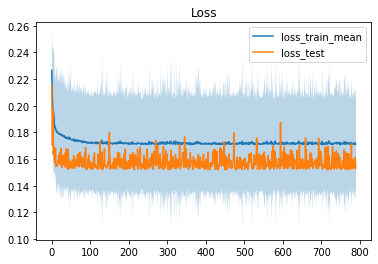

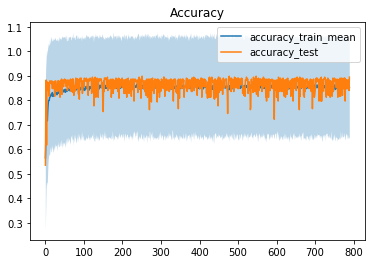

In [9]:
import matplotlib.pyplot as plt

plt.title("Loss")
plt.plot(loss_train_mean)
plt.plot(loss_test)
plt.fill_between(np.arange(1,len(loss_train_mean)+1), np.array(loss_train_mean) - np.array(loss_train_std),np.array(loss_train_mean) + np.array(loss_train_std), alpha = 0.3)
plt.legend(['loss_train_mean','loss_test'])
plt.show()


plt.title("Accuracy")
plt.plot(accuracy_train_mean)
plt.plot(accuracy_test)
plt.fill_between(np.arange(1,len(accuracy_train_mean)+1), np.array(accuracy_train_mean) - np.array(accuracy_train_std),np.array(accuracy_train_mean) + np.array(accuracy_train_std), alpha = 0.3)
plt.legend(['accuracy_train_mean','accuracy_test'])
plt.show()


## accuracy and loss table

In [10]:
print("  dataset     |           loss           |          accuracy         |")
print("----------------------------------------------------------------------")
print("   train      |       %.10f       |       %.10f        |"%(loss_train_mean[-1],accuracy_train_mean[-1]))
print("----------------------------------------------------------------------")
print("   test       |       %.10f       |       %.10f        |"%(loss_test[-1],accuracy_test[-1]))
print("----------------------------------------------------------------------")

  dataset     |           loss           |          accuracy         |
----------------------------------------------------------------------
   train      |       0.1712107689       |       0.8529698150        |
----------------------------------------------------------------------
   test       |       0.1528018866       |       0.8945312500        |
----------------------------------------------------------------------
